# Maximum Annual Peak Flow Discharge for Alabama State (MAPFD-AL) through MLR

## Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pickle
from sklearn.inspection import permutation_importance
import time
import math
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import pearsonr
from math import sqrt

## Import Datasets

In [2]:
# Import the training dataset
df_train = pd.read_csv('./data/df_Train_Qpeak_new.csv', converters={'site_no': str}, low_memory=False)

# Import the testing dataset
df_test = pd.read_csv('./data/df_Test_Qpeak_new.csv', converters={'site_no': str}, low_memory=False)

In [3]:
# Spliting the dependent (y) variable and independent (X) variables for training dataset
y_train = df_train[['Q_peak_obs']]
X_train = df_train[['width_bnk', 'depth_bnk', 'width_mean','depth_mean', 
                    'ACC_NDAMS2000', 'CAT_POPDENS00', 'StreamOrde', 'TotDASqKM',
                    'NLCD_Developed_%', 'NLCD_Forest_%','NLCD_Agriculture_%', 
                    'D50_mm_', 'Mean_AI', 'CAT_SILTAVE', 'CAT_CLAYAVE', 'CAT_SANDAVE',
                    'MINELEVSMO', 'SLOPE','QA_cms', 'QC_cms', 'QE_cms', 
                    'WETINDEXCAT', 'RUNOFFCAT','TMEAN8110CAT', 'HYDRLCONDCAT']]

# Spliting the dependent (y) variable and independent (X) variables for testing dataset 
y_test = df_test[['Q_peak_obs']]
X_test = df_test[['width_bnk', 'depth_bnk', 'width_mean','depth_mean', 
                  'ACC_NDAMS2000', 'CAT_POPDENS00', 'StreamOrde', 'TotDASqKM',
                  'NLCD_Developed_%', 'NLCD_Forest_%','NLCD_Agriculture_%', 
                  'D50_mm_', 'Mean_AI', 'CAT_SILTAVE', 'CAT_CLAYAVE', 'CAT_SANDAVE',
                  'MINELEVSMO', 'SLOPE','QA_cms', 'QC_cms', 'QE_cms', 
                  'WETINDEXCAT', 'RUNOFFCAT','TMEAN8110CAT', 'HYDRLCONDCAT']]

## MLR Model

In [4]:
# MLR coefficients obtained through JMP software
Intercept = -0.535243
TotDASqKM_coeff = 0.5335121
Mean_AI_coeff = -3.659945
CAT_SANDAVE_coeff = -0.189748
RUNOFFCAT_coeff = 0.7921756

In [5]:
# Make prediction on training dataset using final MLR model
mlr_pred_train = (10**Intercept) * (X_train['TotDASqKM']**TotDASqKM_coeff) * (X_train['Mean_AI']**Mean_AI_coeff) *(X_train['CAT_SANDAVE']**CAT_SANDAVE_coeff) * (X_train['RUNOFFCAT']**RUNOFFCAT_coeff)
mlr_pred_train = np.array(mlr_pred_train).reshape(-1,)
mlr_pred_log_train = np.array(np.log10(mlr_pred_train)).reshape(-1,) #log transform

# Make prediction on testing dataset using final MLR model
mlr_pred_test = (10**Intercept) * (X_test['TotDASqKM']**TotDASqKM_coeff) * (X_test['Mean_AI']**Mean_AI_coeff) *(X_test['CAT_SANDAVE']**CAT_SANDAVE_coeff) * (X_test['RUNOFFCAT']**RUNOFFCAT_coeff)
mlr_pred_test = np.array(mlr_pred_test).reshape(-1,)
mlr_pred_log_test = np.array(np.log10(mlr_pred_test)).reshape(-1,) #log transform

## Observation

In [6]:
y_test1 = np.array(y_test).reshape(-1,)
y_test_log = np.array(np.log10(y_test1)).reshape(-1,) #log transform

y_train1 = np.array(y_train).reshape(-1,)
y_train_log = np.array(np.log10(y_train1)).reshape(-1,) #log transform

## Validation through Performance Metrics

In [7]:
Metrics= pd.DataFrame()

Model_names= ['MLR_train', 'MLR_test']
pred_list= [mlr_pred_train, mlr_pred_test]

obs_list = [y_train1, y_test1, y_train1, y_test1]
for i in range(0,2):
    Model_name= Model_names[i]
    Y = pred_list[i]
    X = obs_list[i]
    r2 = np.corrcoef(X, Y)[0, 1]**2
    abs_pbias = 100 * np.sum(abs(Y - X)) / np.sum(X)
    nse = 1 - np.sum((X - Y)**2) / np.sum((X - np.mean(X))**2)
    rmse = np.sqrt(np.mean(np.square(X - Y)))
    r = np.corrcoef(X, Y)[0, 1]
    s = np.std(Y) / np.std(X)
    b = np.mean(Y) / np.mean(X)
    kge = 1 - np.sqrt((r - 1)**2 + (s - 1)**2 + (b - 1)**2)
    df = pd.DataFrame({f'{Model_name}': [ format(r2, ".2f"), format(nse, ".2f"), format(kge, ".2f"), format(abs_pbias, ".2f"), format(rmse, ".2f")]})
    Metrics= pd.concat([df, Metrics], axis=1)

Metrics = Metrics.rename( index={  0:'R2', 1:'NSE', 2:'KGE', 3:'APB (%)',  4:'RMSE (m)'})
Metrics.style

,MLR_test,MLR_train
R2,0.74,0.85
NSE,0.43,0.85
KGE,0.55,0.90
APB (%),40.99,28.94
RMSE (m),1558.72,819.84


## Visualization of Scatter and Violin Plots for Training and Testing Datasets 

Text(0.5, 0.98, 'Maximum Annual Peak Flow Discharge - MLR model\n ')

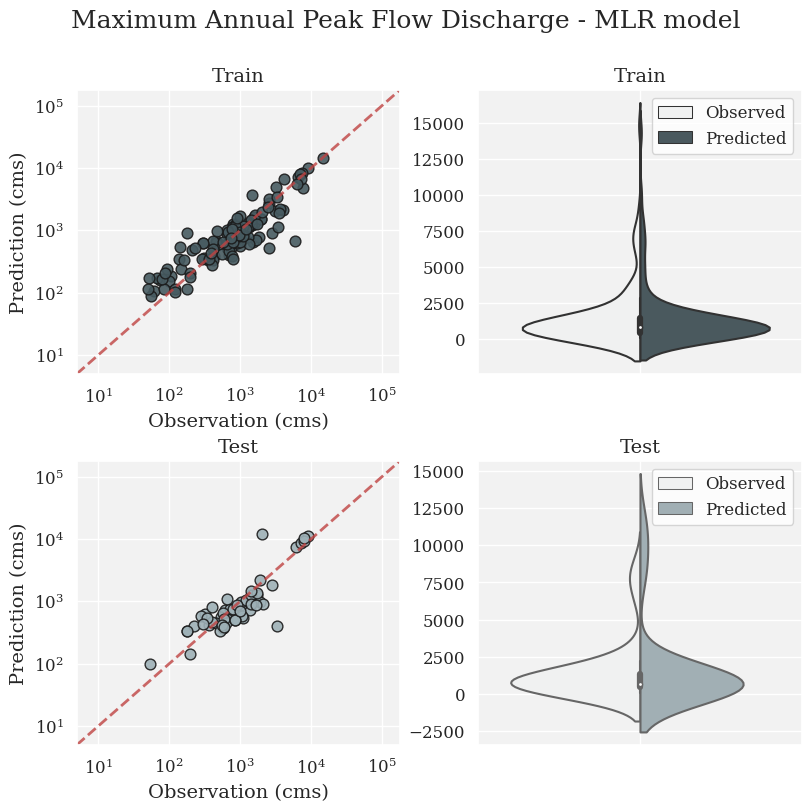

In [8]:
sns.set(style='darkgrid')
plt.rcParams.update({'font.family': 'serif'})

Model_names= ['Train', 'Test']
pred_list=  [mlr_pred_train, mlr_pred_test]
obs_list = [y_train1, y_test1]
fc= ['#475B61', '#9EB1B7']
    
    
fig, axs = plt.subplots(2,2, figsize=(8, 8), constrained_layout=True)

for i in range(0,2):
    X = obs_list[i]
    Y = pred_list[i]
    max_value = 100000
    min_value =  10
    axs[i,0].scatter(X, Y, color=fc[i], edgecolor='k', alpha=0.9, s=60)  
    axs[i,0].set_yscale('log')
    axs[i,0].set_xscale('log')
    axs[i,0].plot([0.5*min_value, 1.8*max_value], [0.5*min_value, 1.8*max_value], '--', color='#bf4342', linewidth=2, alpha=0.8)
    axs[i,0].set_xlabel("Observation (cms)", fontsize=14)
    axs[i,0].set_ylabel("Prediction (cms)", fontsize=14)
    axs[i,0].grid(True)
    axs[i,0].set_xlim(0.5*min_value, 1.8*max_value)
    axs[i,0].set_ylim(0.5*min_value, 1.8*max_value)
    axs[i,0].set_facecolor("#f2f2f2")   
    axs[i,0].set_title(Model_names[i], size=14)
    axs[i,0].tick_params(labelsize=12)
       
    data_train = pd.DataFrame({'Observed':X, 'Predicted':Y})
    data_train = data_train.melt()
    data_train.rename(columns = {'value':'counts'}, inplace = True)
    data_train[' '] = ' '

    sns.violinplot(data = data_train, y= 'counts', split=True, hue='variable',  x=' ', color=fc[i], ax=axs[i,1])
    axs[i,1].set_facecolor("#f2f2f2")  
    axs[i,1].grid(True)
    axs[i,1].set_ylabel("", fontsize=12)
    axs[i,1].set_title(Model_names[i], size=14)
    axs[i,1].tick_params(labelsize=12)
    axs[i,1].legend(title=False ,facecolor = "w",fontsize=12)

fig.suptitle('Maximum Annual Peak Flow Discharge - MLR model\n ', size=18, x= 0.5)
